In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import random

In [2]:
d = 23

In [3]:
import random

complex_type = torch.cdouble
real_type = torch.double

v = torch.ones(d, dtype=complex_type)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)
    
U = torch.zeros(d, d, dtype=complex_type, requires_grad=False)
for i in range(d):
    U[:,i] = v ** i / math.sqrt(d)
    
U = U.conj()

In [4]:
# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
# distribution of each entry
probs = torch.ones(d, d)

# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
n = d * d

X = torch.zeros(n, 2 * d)
Y = torch.zeros(n, d)
targets = torch.zeros(n, dtype=torch.int)

for i in range(n):
    j, k = i // d, i % d
    X[i, j] = 1
    X[i, k + d] = 1
    Y[i, mul_table[j, k]] = 1
    targets[i] = mul_table[j, k]
    
# Normalized one hot.
# X = X - 2 / d
# Y = Y - 1 / d

# sort according to y.
sorted_targets, y_indices = targets.sort()

# Specify the distribution of data
probs = (torch.rand(n) > 0.2).float()

print((probs == 1).sum())
# probs = torch.rand(n)
# probs = torch.ones(n)

# Then 

tensor(427)


In [5]:
# compute the backpropagated gradient

def compute_dF(F, probs, Y, eps):
    est_W = (F.t() @ probs.diag() @ F + eps * torch.eye(F.size(1)).to(F.device)).inverse() @ (F.t() @ probs.diag() @ Y)

    hatY = F @ est_W
    dF = probs.diag() @ (Y - hatY) @ est_W.t()
    
    return dF

In [6]:
def compute_dF2(F, probs, Y, eps):
    # Compute the eigenvector of F.t() @ probs.diag() @ F. 
    est_W = F.t() @ probs.diag() @ Y

    hatY = F @ est_W
    dF = probs.diag() @ (Y - hatY) @ est_W.t()
    
    return dF

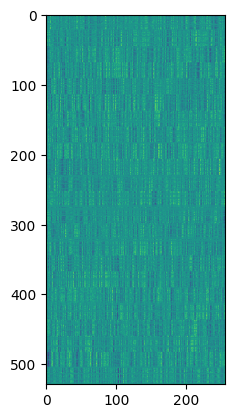

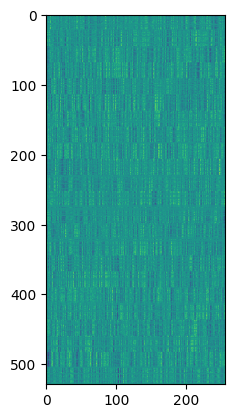

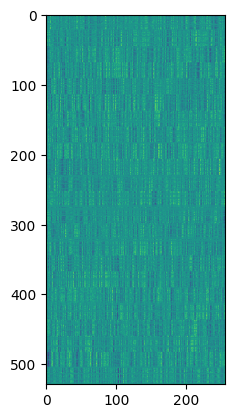

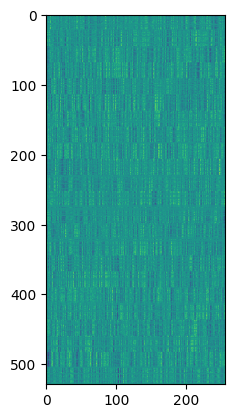

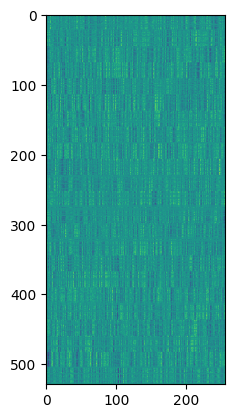

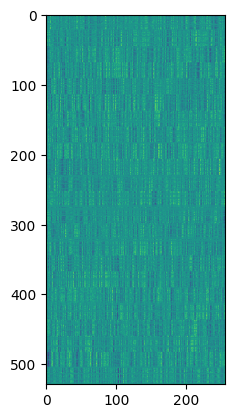

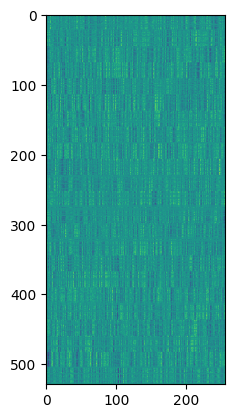

In [7]:
# compute_dF and check its structure
K = 1024
F = torch.randn(n, K)
# F = F ** 2

# F = F - F.mean(dim=1, keepdim=True)

for eps in [1e-3, 1e-2, 1e-1, 2e-1, 3e-1, 5e-1, 1]:
    dF = compute_dF2(F, probs, Y, eps)
    plt.imshow(dF[y_indices,:256])
    plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

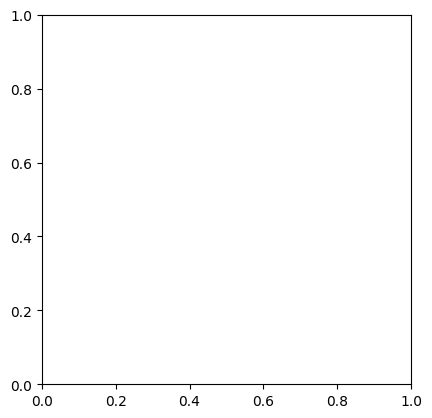

In [242]:
plt.imshow(dF[y_indices[:2*d],:256])

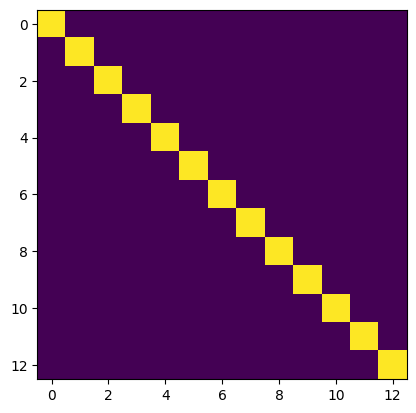

In [120]:
plt.imshow(Y.t() @ Y)

In [86]:
probs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [122]:
probs.diag()

tensor([[0.4568, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0940, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4509,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.8159, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1452, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0912]])

In [28]:
y_indices

tensor([43, 37, 31, 25, 19, 13,  0,  7,  1, 32, 38, 26, 20, 44, 14, 45, 33,  8,
         2, 39, 27, 15, 34,  9,  3, 40, 21, 46, 10, 41, 28, 22,  4, 16, 47, 48,
        35, 29, 23, 17, 11,  5, 36, 30, 24, 42, 18, 12,  6])

In [30]:
sorted_targets

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6], dtype=torch.int32)

In [31]:
targets[y_indices]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6], dtype=torch.int32)

In [33]:
dF[y_indices,:]

tensor([[ 4.1220e-05, -1.1244e-04, -9.9794e-05,  ...,  2.5571e-04,
         -7.0528e-05, -1.5531e-05],
        [ 8.7528e-06,  3.8684e-04, -3.7546e-05,  ...,  1.9525e-04,
         -6.7284e-05, -4.8323e-04],
        [ 5.6162e-05, -7.9478e-05, -4.7379e-05,  ..., -2.3025e-04,
         -1.1048e-04,  3.3634e-05],
        ...,
        [-1.8350e-04, -2.3147e-04, -8.5033e-04,  ...,  8.1810e-04,
          9.6420e-05,  4.4897e-04],
        [ 2.1295e-04, -1.5683e-04,  5.9404e-04,  ..., -1.9516e-04,
          5.2999e-04,  4.8419e-04],
        [ 2.0057e-04,  4.2506e-05,  1.4783e-04,  ..., -2.9313e-04,
         -3.2939e-04, -4.0468e-04]])

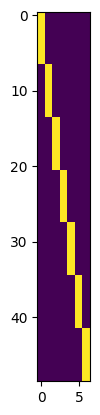

In [35]:
plt.imshow(Y[y_indices,:])

In [10]:
#compute frequency contrastiveness
def freq_contr(v):
    d = v.size(0)
    freq_mag = (U.t() @ v.to(complex_type)).abs()
    freq_mag = freq_mag[1:d//2+1]
    return 2*freq_mag.max() - freq_mag.sum(), freq_mag.max(), freq_mag

torch.Size([256])


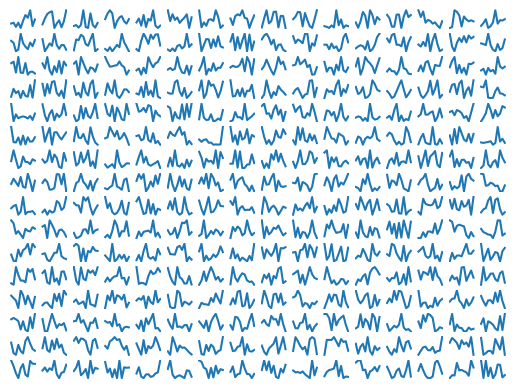

normalized_freq_contr=tensor(-3.5451, dtype=torch.float64)
Mean of stds 0.09966667
std of the mean 0.17012133
Ratio 0.58585644
mean of the abs(mean) 0.13603483


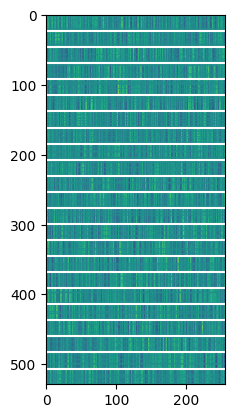

torch.Size([256])


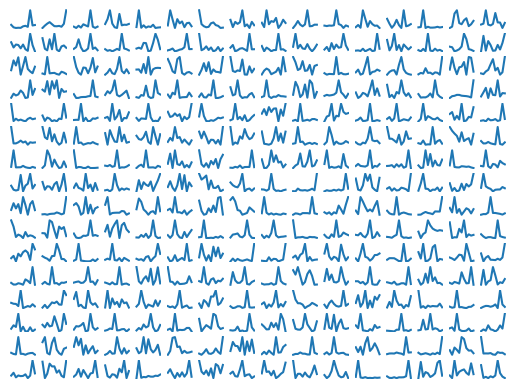

normalized_freq_contr=tensor(-1.1512, dtype=torch.float64)
Mean of stds 0.00083921687
std of the mean 0.0004895985
Ratio 1.714092
mean of the abs(mean) 0.00039980805


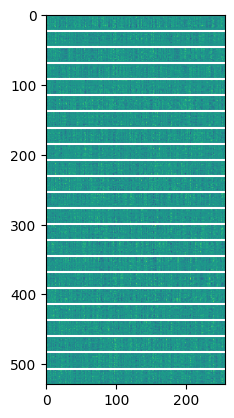

torch.Size([256])


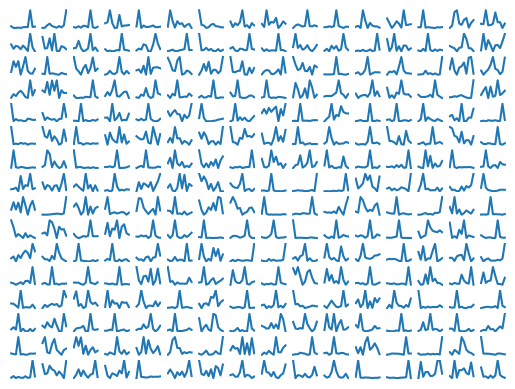

normalized_freq_contr=tensor(-0.6042, dtype=torch.float64)
Mean of stds 0.00057099725
std of the mean 0.0003608705
Ratio 1.5822774
mean of the abs(mean) 0.00028331488


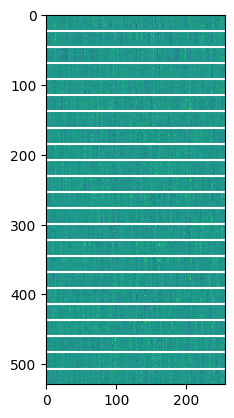

torch.Size([256])


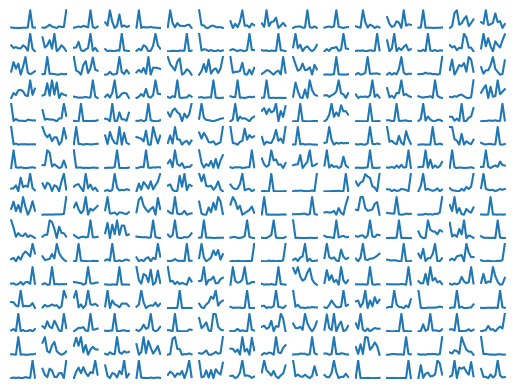

normalized_freq_contr=tensor(-0.1658, dtype=torch.float64)
Mean of stds 0.00037210586
std of the mean 0.00029353148
Ratio 1.2676864
mean of the abs(mean) 0.00020425583


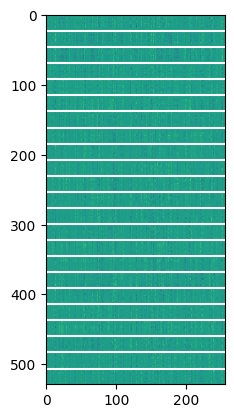

torch.Size([256])


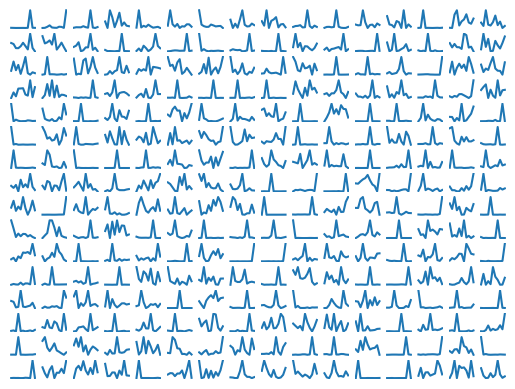

normalized_freq_contr=tensor(0.1050, dtype=torch.float64)
Mean of stds 0.00020229252
std of the mean 0.00025651845
Ratio 0.7886081
mean of the abs(mean) 0.00015166694


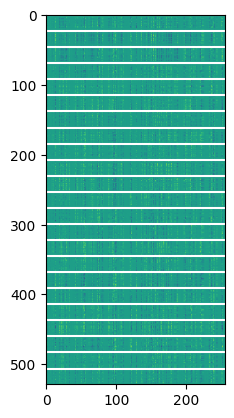

torch.Size([249])


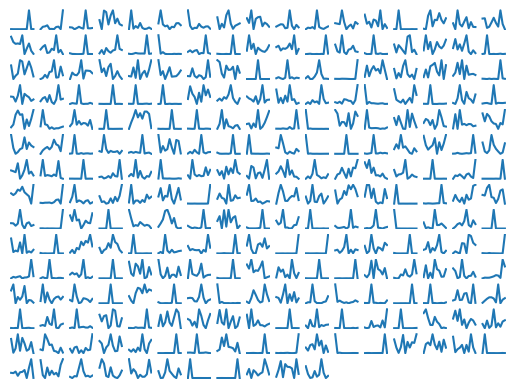

normalized_freq_contr=tensor(0.2866, dtype=torch.float64)
Mean of stds 0.00013637531
std of the mean 0.00024446507
Ratio 0.5578519
mean of the abs(mean) 0.00012754588


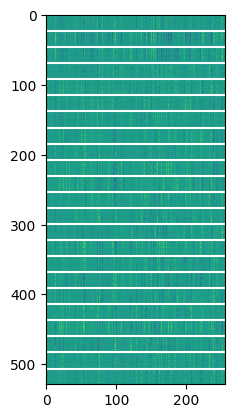

torch.Size([181])


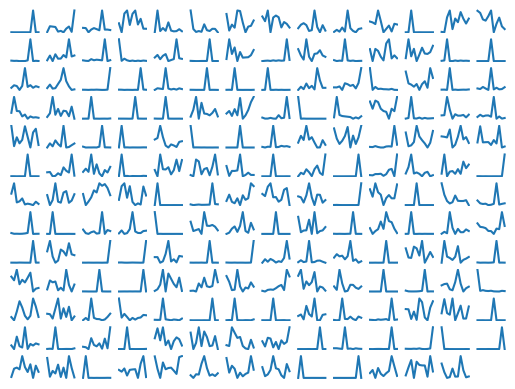

normalized_freq_contr=tensor(0.5614, dtype=torch.float64)
Mean of stds 0.00015667028
std of the mean 0.0002803042
Ratio 0.5589295
mean of the abs(mean) 0.00015408693


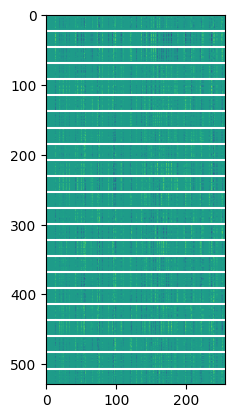

torch.Size([106])


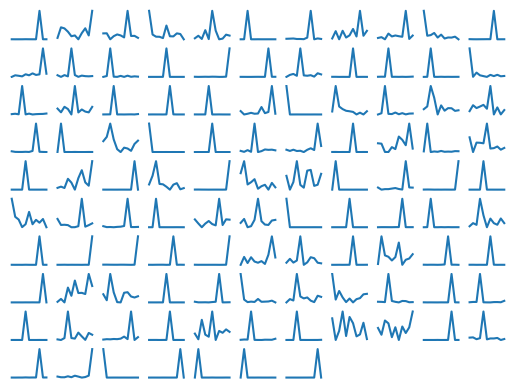

normalized_freq_contr=tensor(0.8012, dtype=torch.float64)
Mean of stds 0.00023646474
std of the mean 0.00036208273
Ratio 0.65306824
mean of the abs(mean) 0.00023917682


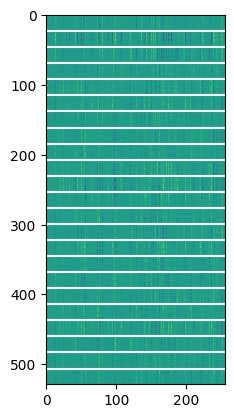

torch.Size([78])


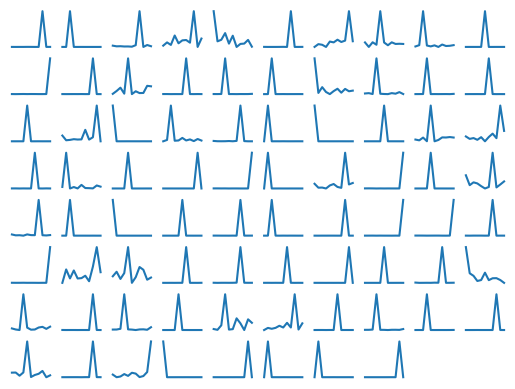

normalized_freq_contr=tensor(0.8940, dtype=torch.float64)
Mean of stds 0.00027100326
std of the mean 0.00041842813
Ratio 0.6476698
mean of the abs(mean) 0.00030459213


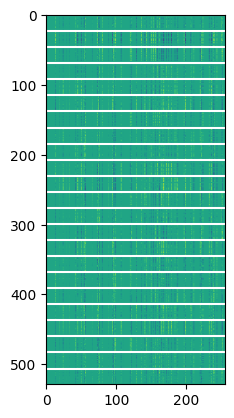

torch.Size([71])


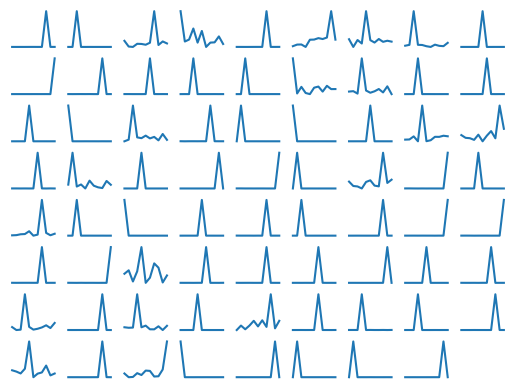

normalized_freq_contr=tensor(0.9211, dtype=torch.float64)
Mean of stds 0.0002488504
std of the mean 0.00042980962
Ratio 0.57897824
mean of the abs(mean) 0.00031631452


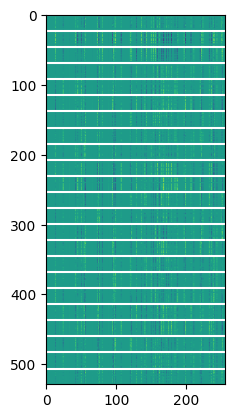

torch.Size([62])


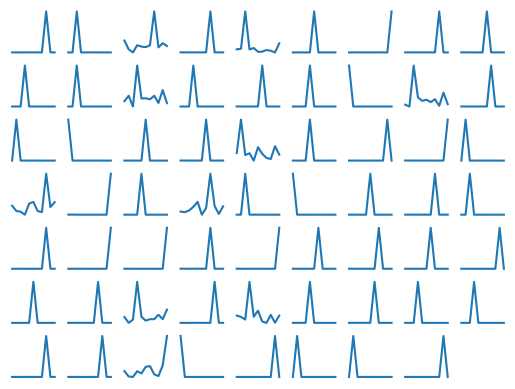

normalized_freq_contr=tensor(0.9585, dtype=torch.float64)
Mean of stds 0.00027515463
std of the mean 0.0004591214
Ratio 0.59930694
mean of the abs(mean) 0.0003567041


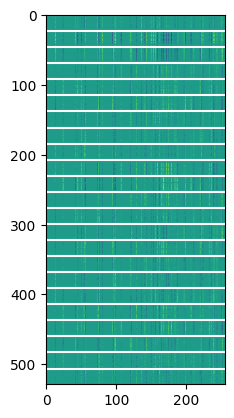

torch.Size([55])


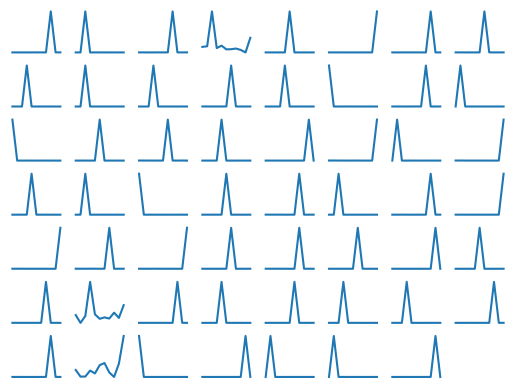

normalized_freq_contr=tensor(0.9842, dtype=torch.float64)
Mean of stds 0.00030848276
std of the mean 0.00048739015
Ratio 0.6329278
mean of the abs(mean) 0.00040037197


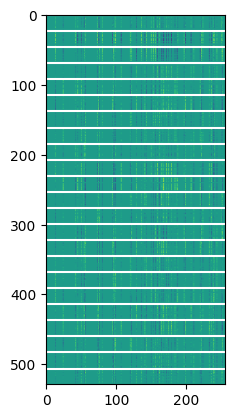

torch.Size([52])


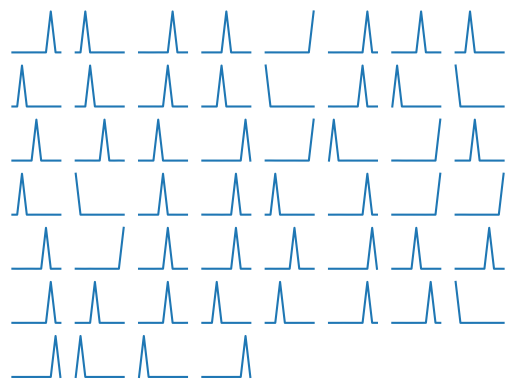

normalized_freq_contr=tensor(0.9944, dtype=torch.float64)
Mean of stds 0.00032613229
std of the mean 0.0005012593
Ratio 0.65062594
mean of the abs(mean) 0.00042315372


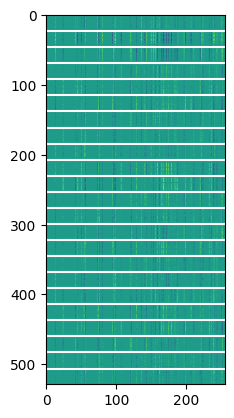

torch.Size([52])


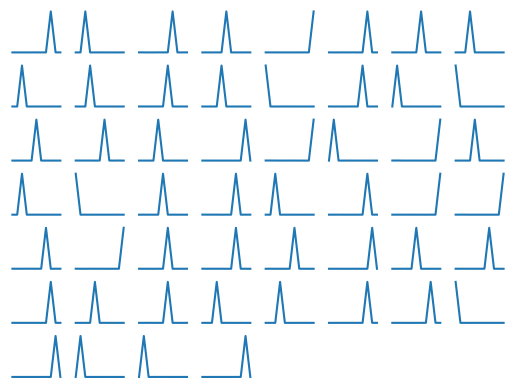

normalized_freq_contr=tensor(0.9944, dtype=torch.float64)
Mean of stds 0.000326116
std of the mean 0.00050126086
Ratio 0.6505914
mean of the abs(mean) 0.0004231203


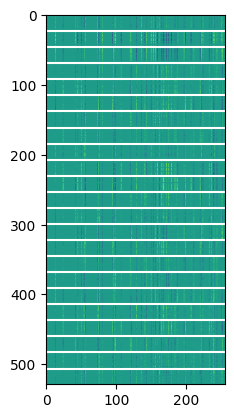

torch.Size([52])


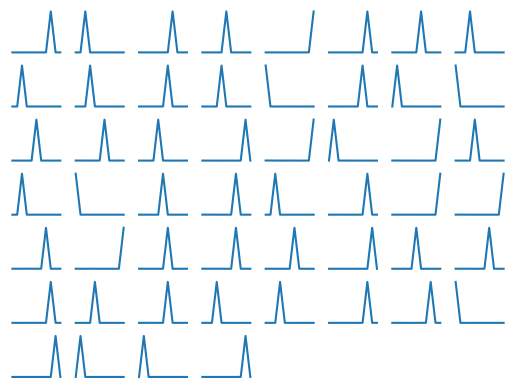

normalized_freq_contr=tensor(0.9944, dtype=torch.float64)
Mean of stds 0.0003268723
std of the mean 0.00050124375
Ratio 0.65212244
mean of the abs(mean) 0.00042308058


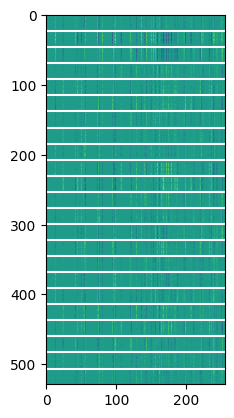

torch.Size([52])


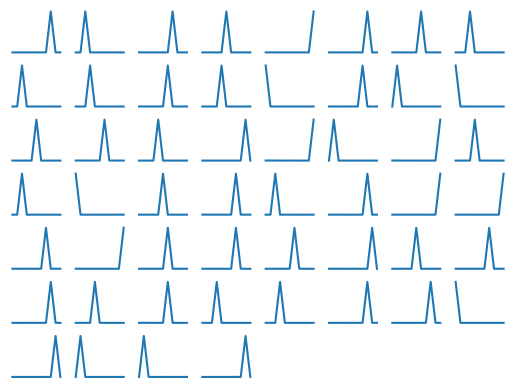

normalized_freq_contr=tensor(0.9943, dtype=torch.float64)
Mean of stds 0.0003289314
std of the mean 0.00050132157
Ratio 0.6561286
mean of the abs(mean) 0.00042313535


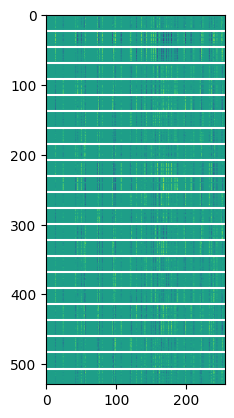

torch.Size([52])


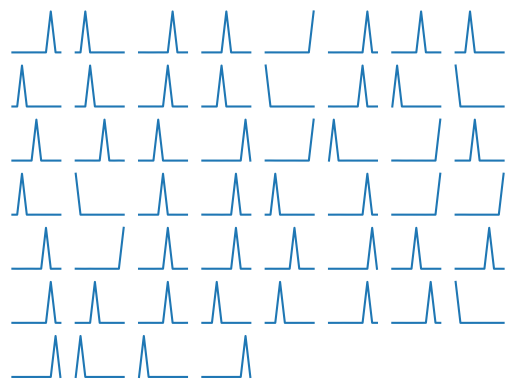

normalized_freq_contr=tensor(0.9943, dtype=torch.float64)
Mean of stds 0.0003279023
std of the mean 0.0005012099
Ratio 0.6542215
mean of the abs(mean) 0.00042303978


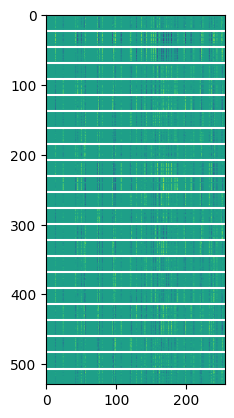

torch.Size([52])


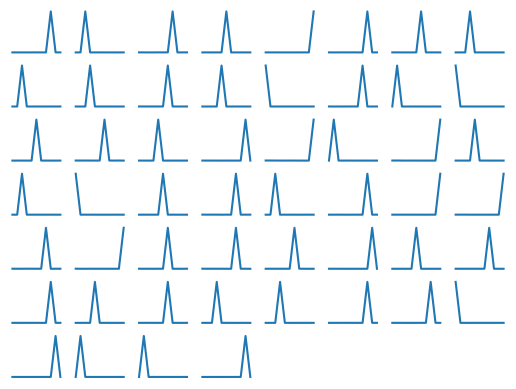

normalized_freq_contr=tensor(0.9943, dtype=torch.float64)
Mean of stds 0.00033075706
std of the mean 0.00050121505
Ratio 0.65991044
mean of the abs(mean) 0.00042299103


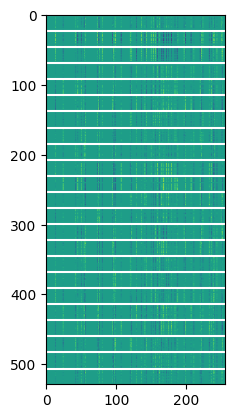

torch.Size([52])


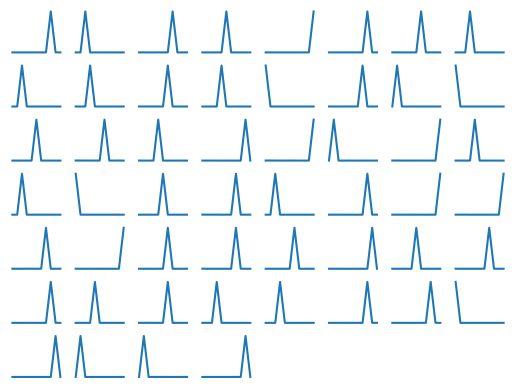

normalized_freq_contr=tensor(0.9943, dtype=torch.float64)
Mean of stds 0.00033100546
std of the mean 0.00050122925
Ratio 0.66038734
mean of the abs(mean) 0.0004230006


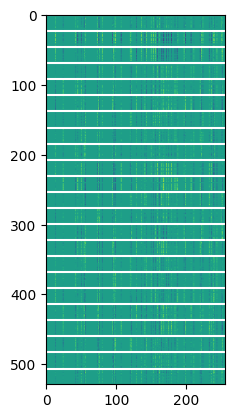

torch.Size([52])


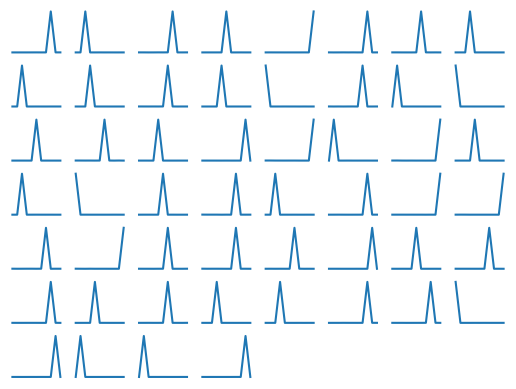

normalized_freq_contr=tensor(0.9943, dtype=torch.float64)
Mean of stds 0.00032762802
std of the mean 0.00050128443
Ratio 0.6535771
mean of the abs(mean) 0.00042304007


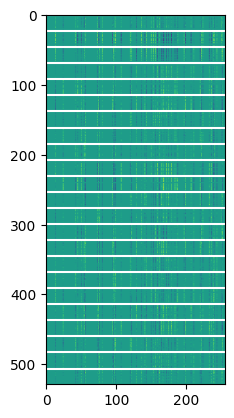

torch.Size([52])


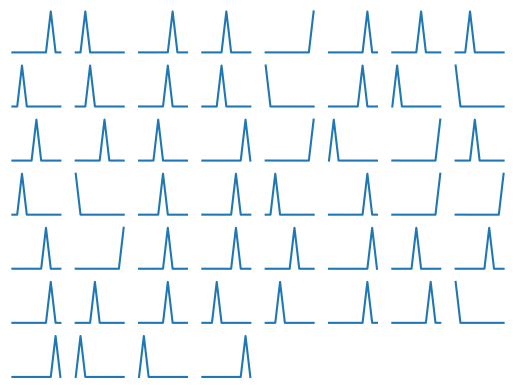

normalized_freq_contr=tensor(0.9942, dtype=torch.float64)
Mean of stds 0.0003411339
std of the mean 0.00050144544
Ratio 0.6803012
mean of the abs(mean) 0.00042315052


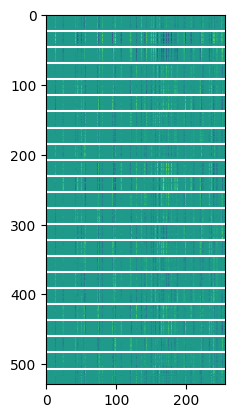

torch.Size([52])


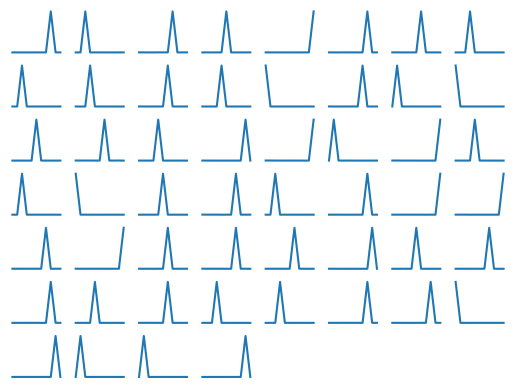

normalized_freq_contr=tensor(0.9942, dtype=torch.float64)
Mean of stds 0.00035028256
std of the mean 0.00050117157
Ratio 0.6989274
mean of the abs(mean) 0.00042287537


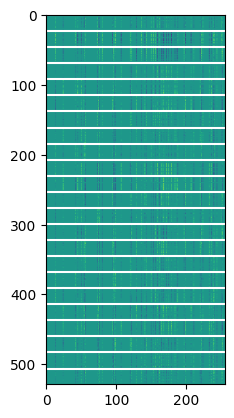

torch.Size([52])


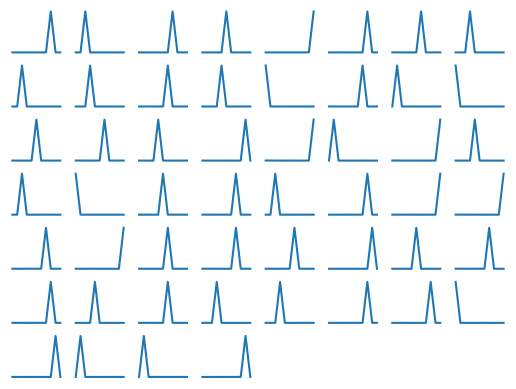

normalized_freq_contr=tensor(0.9936, dtype=torch.float64)
Mean of stds 0.00061288907
std of the mean 0.00050510257
Ratio 1.2133952
mean of the abs(mean) 0.00042578706


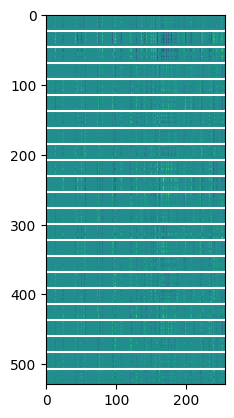

torch.Size([52])


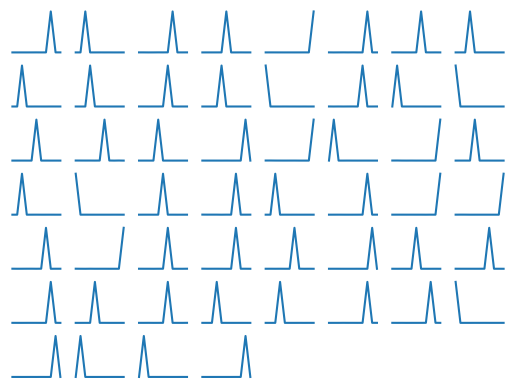

normalized_freq_contr=tensor(0.9941, dtype=torch.float64)
Mean of stds 0.0003552256
std of the mean 0.0005015067
Ratio 0.70831674
mean of the abs(mean) 0.00042308125


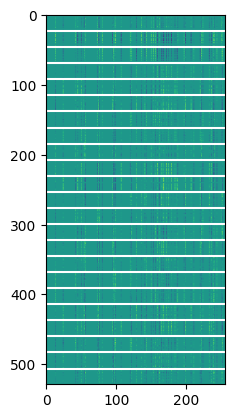

torch.Size([52])


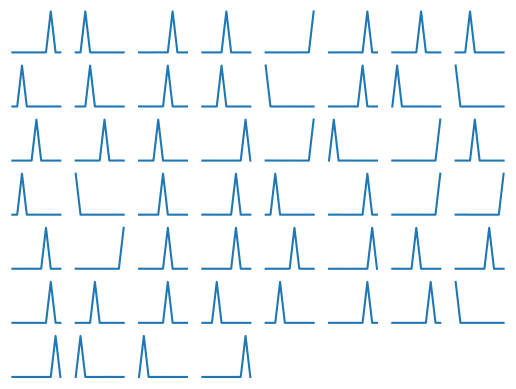

normalized_freq_contr=tensor(0.9933, dtype=torch.float64)
Mean of stds 0.0006594904
std of the mean 0.00050596107
Ratio 1.303441
mean of the abs(mean) 0.00042634943


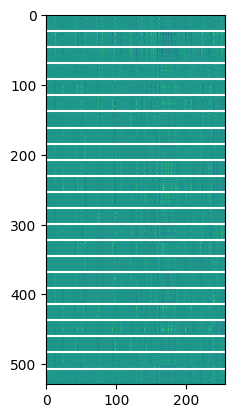

torch.Size([52])


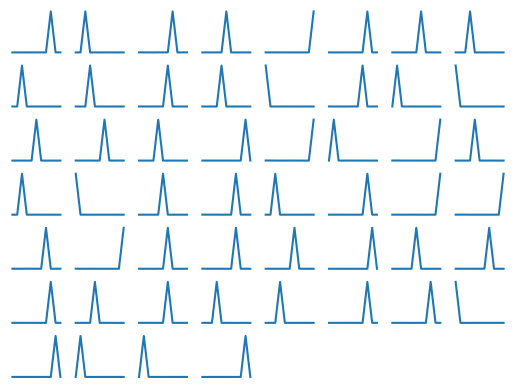

normalized_freq_contr=tensor(0.9941, dtype=torch.float64)
Mean of stds 0.00034756702
std of the mean 0.0005013847
Ratio 0.69321424
mean of the abs(mean) 0.00042301614


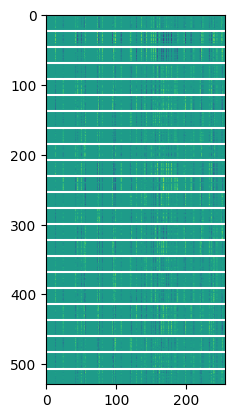

torch.Size([52])


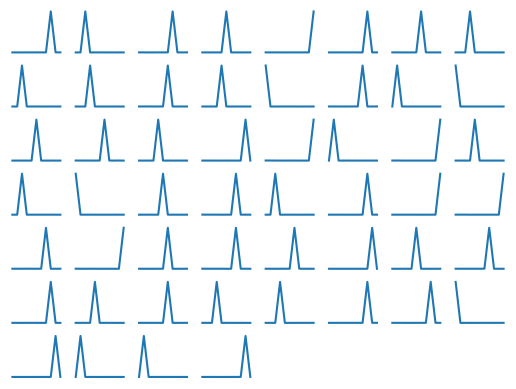

normalized_freq_contr=tensor(0.9940, dtype=torch.float64)
Mean of stds 0.0004356048
std of the mean 0.0005023249
Ratio 0.8671774
mean of the abs(mean) 0.00042367066


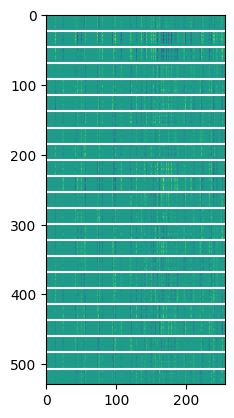

torch.Size([52])


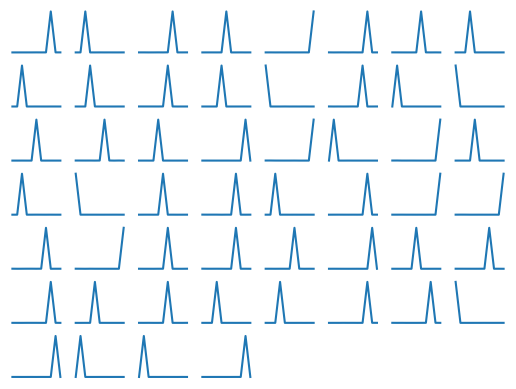

normalized_freq_contr=tensor(0.9938, dtype=torch.float64)
Mean of stds 0.00044950488
std of the mean 0.00050255697
Ratio 0.89443564
mean of the abs(mean) 0.00042383233


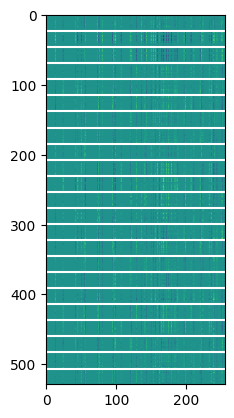

torch.Size([52])


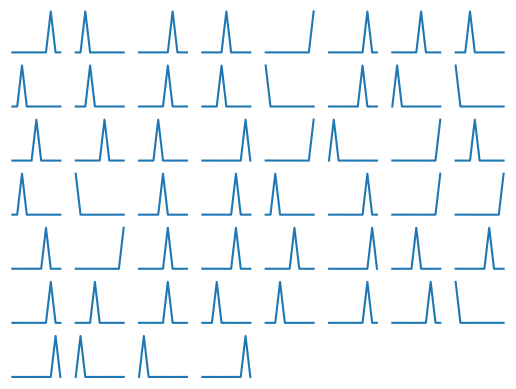

normalized_freq_contr=tensor(0.9940, dtype=torch.float64)
Mean of stds 0.00035082735
std of the mean 0.0005006233
Ratio 0.7007811
mean of the abs(mean) 0.00042231492


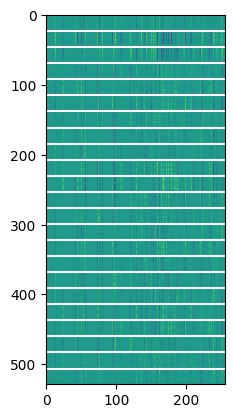

torch.Size([52])


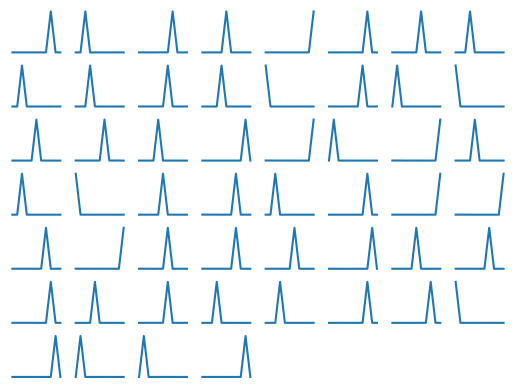

normalized_freq_contr=tensor(0.9935, dtype=torch.float64)
Mean of stds 0.00058446353
std of the mean 0.0005048157
Ratio 1.157776
mean of the abs(mean) 0.00042540403


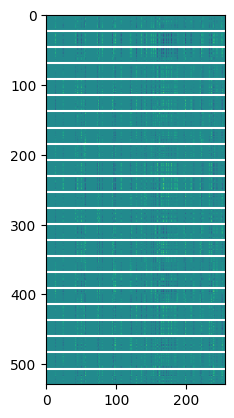

torch.Size([52])


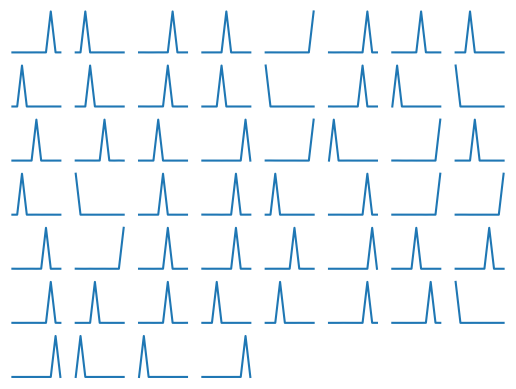

normalized_freq_contr=tensor(0.9938, dtype=torch.float64)
Mean of stds 0.00042188418
std of the mean 0.0005019279
Ratio 0.8405274
mean of the abs(mean) 0.00042324


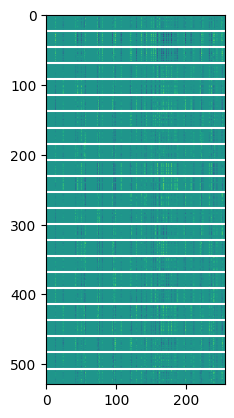

torch.Size([52])


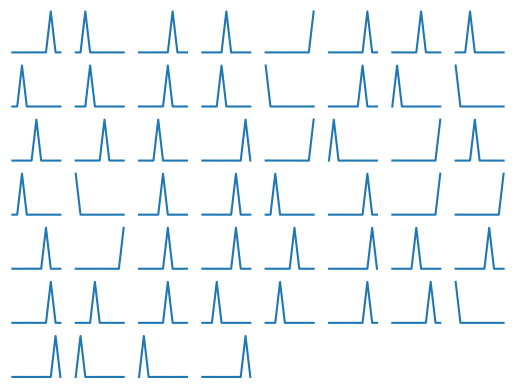

normalized_freq_contr=tensor(0.9935, dtype=torch.float64)
Mean of stds 0.00055064296
std of the mean 0.00050324394
Ratio 1.094187
mean of the abs(mean) 0.00042416857


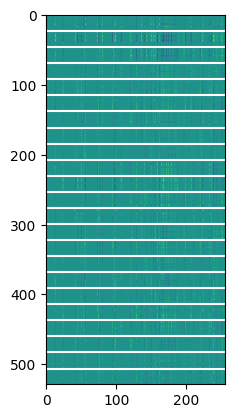

torch.Size([52])


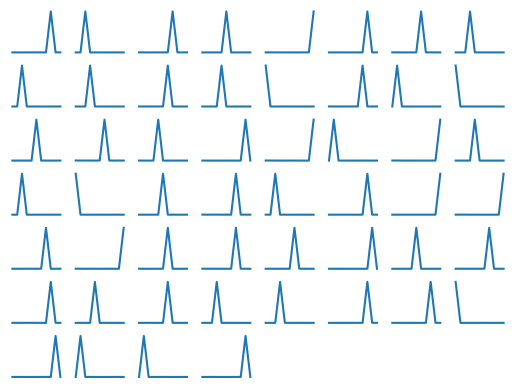

normalized_freq_contr=tensor(0.9932, dtype=torch.float64)
Mean of stds 0.0006750204
std of the mean 0.00050598837
Ratio 1.334063
mean of the abs(mean) 0.00042620863


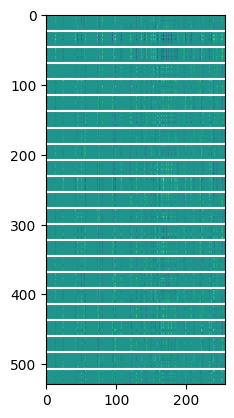

torch.Size([52])


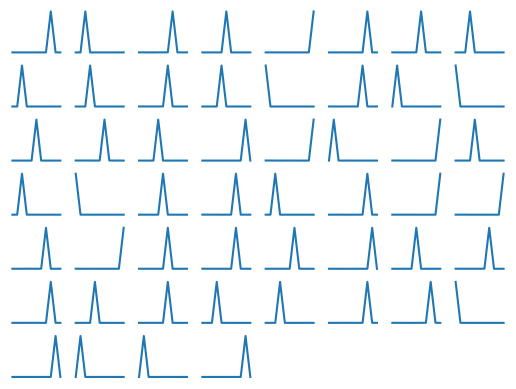

normalized_freq_contr=tensor(0.9936, dtype=torch.float64)
Mean of stds 0.0004188117
std of the mean 0.00050180213
Ratio 0.8346152
mean of the abs(mean) 0.00042303235


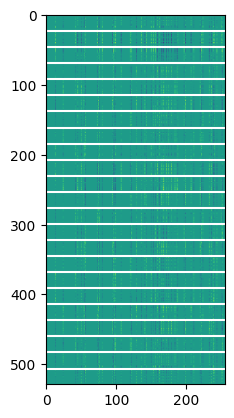

torch.Size([52])


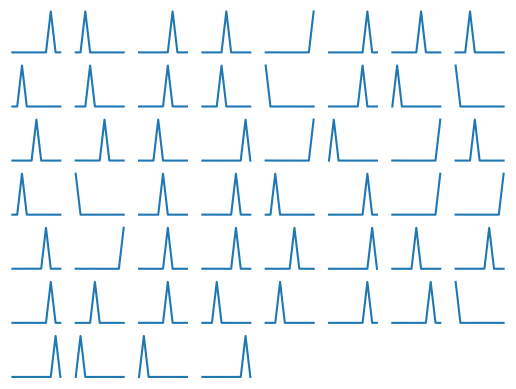

normalized_freq_contr=tensor(0.9935, dtype=torch.float64)
Mean of stds 0.00049890653
std of the mean 0.00050248153
Ratio 0.9928853
mean of the abs(mean) 0.00042353466


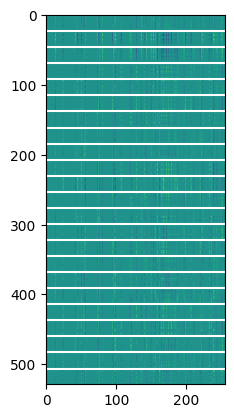

torch.Size([52])


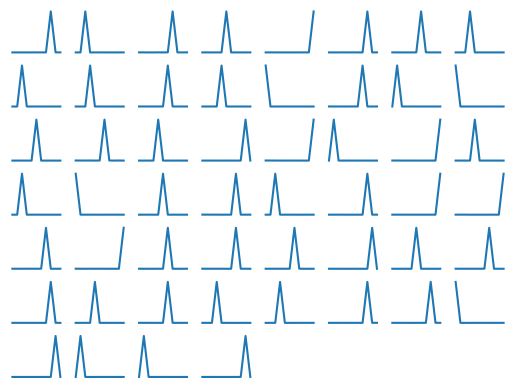

normalized_freq_contr=tensor(0.9936, dtype=torch.float64)
Mean of stds 0.00042757575
std of the mean 0.00050188473
Ratio 0.85194016
mean of the abs(mean) 0.00042294245


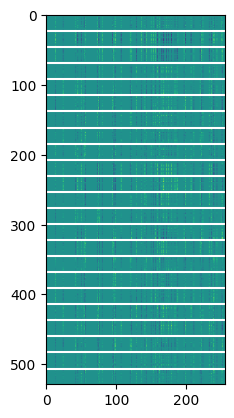

torch.Size([52])


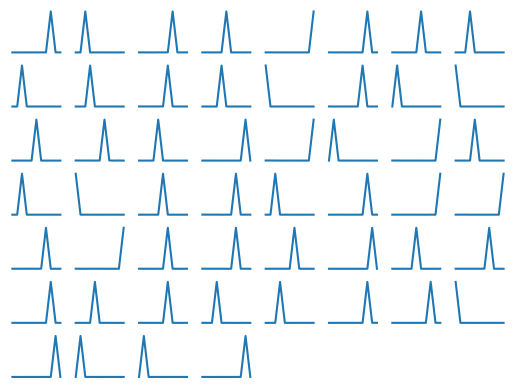

normalized_freq_contr=tensor(0.9935, dtype=torch.float64)
Mean of stds 0.00037609326
std of the mean 0.00050156424
Ratio 0.7498407
mean of the abs(mean) 0.0004227561


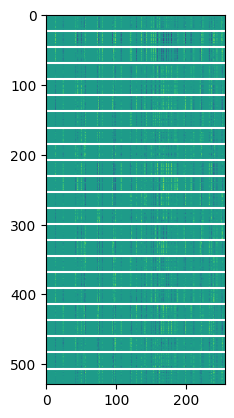

torch.Size([52])


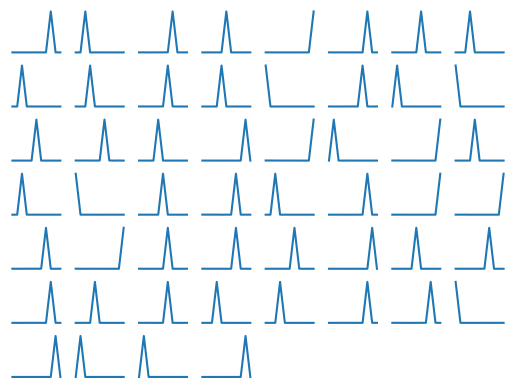

normalized_freq_contr=tensor(0.9932, dtype=torch.float64)
Mean of stds 0.00046470985
std of the mean 0.0005027091
Ratio 0.924411
mean of the abs(mean) 0.00042356606


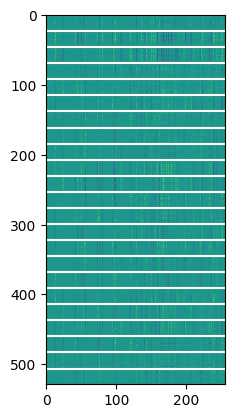

torch.Size([52])


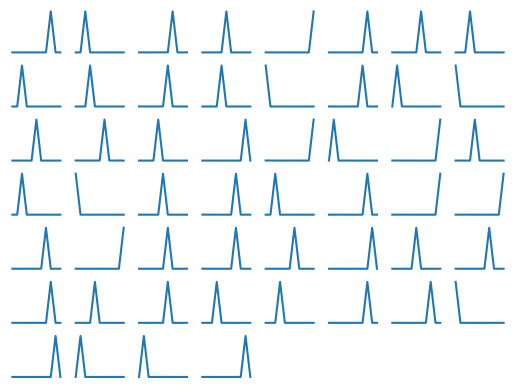

normalized_freq_contr=tensor(0.9935, dtype=torch.float64)
Mean of stds 0.00036109096
std of the mean 0.00050136744
Ratio 0.7202122
mean of the abs(mean) 0.00042253514


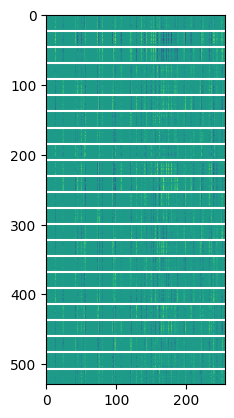

torch.Size([52])


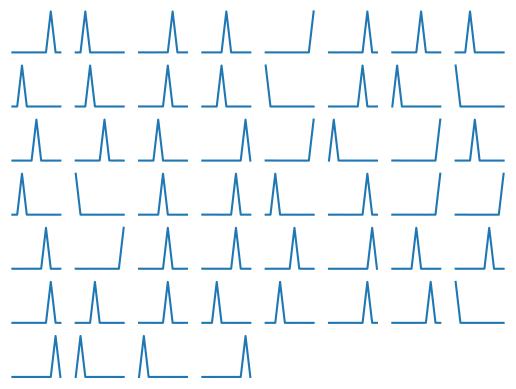

normalized_freq_contr=tensor(0.9933, dtype=torch.float64)
Mean of stds 0.00043666357
std of the mean 0.00050194154
Ratio 0.86994904
mean of the abs(mean) 0.00042282793


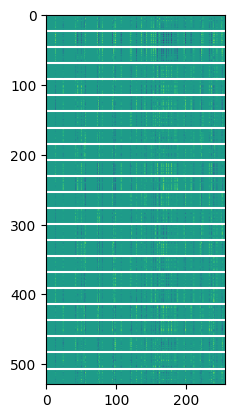

In [12]:
### Run some dynamics given the backpropagated gradient.

K = 256
W = nn.Linear(2*d, K, bias=False)

X = X.cuda()
W = W.cuda()
Y = Y.cuda()
probs = probs.cuda()

eps = 1e-1

# optimizer
optimizer = torch.optim.Adam(W.parameters(), lr=0.01, weight_decay=5e-5)

est_upper_W = None

hatYs = []
Ds = []

activation = "sqr"

for t in range(4000):
    optimizer.zero_grad()
    
    # 
    W.train()
    F = W(X)
    
    if activation == "sqr":
        F = F.pow(2)
    elif activation == "relu":
        F[F<0] = 0
    else:
        raise RuntimeError(f"unknown activation {activation}")
        
    # Do normalization
    # F = F - F.mean(dim=0, keepdim=True)
    # F = F / (F.pow(2).mean(dim=0, keepdim=True) + 1e-1).sqrt()
    
    with torch.no_grad():
        dF = compute_dF(F, probs, Y, eps)
    
    if t % 100 == 0:
        w = W.weight.detach()

        indices = (w.norm(dim=1) > 0.2).nonzero().squeeze()
        print(indices.size())

        sum_freq_contr = 0
        sum_freq_max = 0
        
        n_row = int(math.sqrt(indices.size(0)))
        n_col = (indices.size(0) + n_row - 1) // n_row

        for idx, i in enumerate(indices):
            v = w[i, :d].cpu()
            contr, max_value, freq_mag = freq_contr(v)
            sum_freq_contr += contr
            sum_freq_max += max_value
            plt.subplot(n_row, n_col, idx + 1)
            plt.plot(freq_mag)
            plt.axis('off')
        plt.show()

        normalized_freq_contr = sum_freq_contr / sum_freq_max
        print(f"{normalized_freq_contr=}")
        
        # Print out dF
        # plt.imshow(dF[y_indices, :].detach().cpu().numpy())
        # plt.show()
        
        # Check if dF[:, i] has the nice blocky structure
        with torch.no_grad():
            dF_sel = dF[y_indices, :][:, indices]
            all_stds = []
            all_means = []
            for i in range(d):
                sec = dF_sel[i*d:(i+1)*d, :]
                all_stds.append(sec.std(dim=0))
                all_means.append(sec.mean(dim=0))
                
            all_stds = torch.stack(all_stds, dim=1)
            all_means = torch.stack(all_means, dim=1)
            
        print("Mean of stds", all_stds.mean().cpu().numpy())
        print("std of the mean", all_means.std().cpu().numpy())
        print("Ratio", all_stds.mean().cpu().numpy() / all_means.std().cpu().numpy())
        print("mean of the abs(mean)", all_means.abs().mean().cpu().numpy())
        
        plt.imshow(dF[y_indices,:].cpu().numpy())
        for i in range(d):
            plt.axhline(i*d, color='w')
        plt.show()
    
    loss = -(dF * F).sum() / F.size(0) * 2
    loss.backward()
    
    optimizer.step()
    
# plt.legend()
# plt.show()


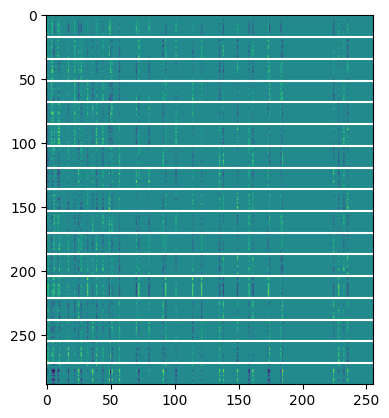

In [173]:
plt.imshow(dF[y_indices,:].cpu().numpy())
for i in range(d):
    plt.axhline(i*d, color='w')

In [134]:
# check the eigenvectors of the data matrix
A = 0

c = torch.randn(d)

for k in range(d):
    sel = (targets == k)
    rho = (torch.rand(d) + 10) * c[k]
    X_sel = X[sel, :]
    A = A + X_sel.t() @ rho.diag() @ X_sel
    
D, V = torch.linalg.eigh(A)
D = D.flip(-1)
V = V.flip(-1)

In [17]:
def plot_freq(v):
    plt.plot((U.t() @ v.to(complex_type)).abs())

In [146]:
probs

tensor([0.4568, 0.0940, 0.4509, 0.5805, 0.1787, 0.8957, 0.2693, 0.3810, 0.6020,
        0.8618, 0.9459, 0.6701, 0.1173, 0.5681, 0.1394, 0.2246, 0.2425, 0.9929,
        0.1137, 0.7165, 0.7482, 0.0509, 0.9641, 0.2815, 0.4266, 0.5847, 0.7480,
        0.6425, 0.2957, 0.0336, 0.1091, 0.0023, 0.7983, 0.7528, 0.2945, 0.4766,
        0.3174, 0.7041, 0.9622, 0.3737, 0.1297, 0.4290, 0.0860, 0.0290, 0.6484,
        0.4552, 0.8415, 0.2754, 0.3353, 0.8665, 0.4262, 0.2705, 0.8879, 0.2230,
        0.6431, 0.6213, 0.4323, 0.1748, 0.5850, 0.6412, 0.2988, 0.3321, 0.8502,
        0.6860, 0.7141, 0.0266, 0.2275, 0.7875, 0.4348, 0.7273, 0.1485, 0.4268,
        0.1906, 0.8227, 0.1775, 0.5802, 0.5837, 0.3649, 0.6396, 0.3946, 0.5554,
        0.5001, 0.1998, 0.0022, 0.0037, 0.6303, 0.1359, 0.9803, 0.8266, 0.1347,
        0.3686, 0.5516, 0.1868, 0.2085, 0.1326, 0.7822, 0.8153, 0.2313, 0.0407,
        0.8016, 0.0849, 0.3144, 0.5162, 0.3618, 0.3568, 0.8059, 0.9659, 0.7674,
        0.8801, 0.7156, 0.6976, 0.2085, 

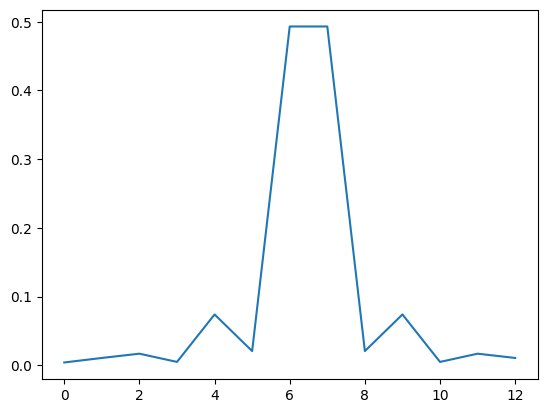

In [135]:
plot_freq(V[:d,0])

In [115]:
V[:,0].shape

torch.Size([14])

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

logger = logging.getLogger("test")

# Setup iterative procedure between solving dF and eigendecomposition of each node. 
K = 512
W = torch.randn(2*d, K).cuda()

X = X.cuda()
Y = Y.cuda()
probs = probs.cuda()

eps = 1
alpha = 0.3
eta = 0.01

dF_accu = 0

# beta = 0.999

for t in range(2000):
    if t % 100 == 0:
        logger.info(f"iter {t}")
        
        
    F = X @ W
    F = F ** 2
    
    # compute dF
    dF = compute_dF(F, probs, Y, eps)
    
    # dF_accu = ((1 - beta) * dF + beta * dF_accu) / (1 - beta**(t+1))
    # dF_accu = dF_accu + dF
    
    # check the eigenvectors of the data matrix
    for j in range(K):
        A = X.t() @ dF[:,j].diag() @ X
        # W[:, j] += alpha * (A @ W[:,j]) - eta * W[:,j]
        
        # Run one step power iteration
        W[:,j] += alpha * A @ W[:,j]
        
        # D, V = torch.linalg.eigh(A)
        # Get the largest eigenvectors and assign it to rows of W
        # if D[-1] < 0:
        #    W[:,j] = 0
        #else:
        #    W[:, j] = V[:, -1]
        
    # Normalize everything
    W = W / W.norm(dim=0, keepdim=True)
        
    # decaying eps
    # if t % 10 == 0:
    #     eps = eps / 2


2025-08-02 22:12:21 - iter 0
2025-08-02 22:12:29 - iter 100
2025-08-02 22:12:35 - iter 200
2025-08-02 22:12:42 - iter 300
2025-08-02 22:12:49 - iter 400
2025-08-02 22:12:56 - iter 500
2025-08-02 22:13:03 - iter 600
2025-08-02 22:13:10 - iter 700
2025-08-02 22:13:17 - iter 800
2025-08-02 22:13:24 - iter 900
2025-08-02 22:13:31 - iter 1000
2025-08-02 22:13:37 - iter 1100
2025-08-02 22:13:44 - iter 1200
2025-08-02 22:13:51 - iter 1300
2025-08-02 22:13:58 - iter 1400


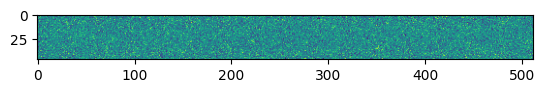

In [28]:
plt.imshow(W.cpu())

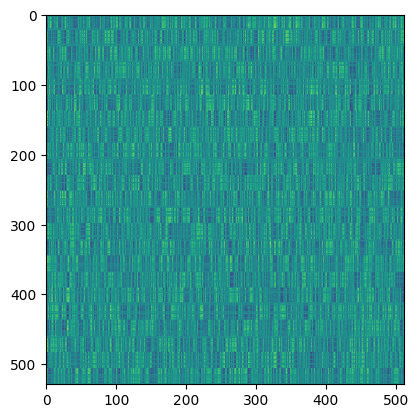

In [24]:
plt.imshow(dF[y_indices,:].cpu())

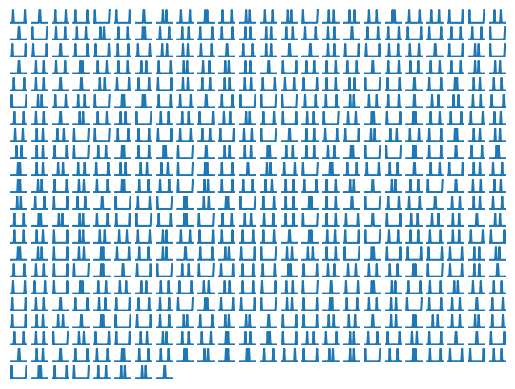

normalized_freq_contr=tensor(0.9330, dtype=torch.float64)


In [51]:
indices = (W.norm(dim=0) > 0.2).nonzero().squeeze().cpu()

active_K = indices.size(0)

n_row = int(math.sqrt(active_K))
n_col = (active_K + n_row - 1) // n_row

sum_freq_contr = 0
sum_freq_max = 0

for idx, j in enumerate(indices.tolist()):
    v = W[:d,j].cpu()
    contr, max_value, freq_mag = freq_contr(v)
    sum_freq_contr += contr
    sum_freq_max += max_value

    plt.subplot(n_row, n_col, idx + 1)
    plot_freq(v)
    plt.axis('off')

plt.show()

normalized_freq_contr = sum_freq_contr / sum_freq_max
print(f"{normalized_freq_contr=}")


In [70]:
indices.size()

torch.Size([81])

In [131]:
probs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 